# Problem 1  
Assume you a call and a put option with the following  
● Current Stock Price $165  
● Current Date 03/03/2023  
● Options Expiration Date 03/17/2023  
● Risk Free Rate of 5.25%  
● Continuously Compounding Coupon of 0.53%  

Calculate the time to maturity using calendar days (not trading days).  
For a range of implied volatilities between 10% and 80%, plot the value of the call and the put.  
Discuss these graphs. How does the supply and demand affect the implied volatility?

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 已知参数
S = 165  # 当前股票价格
K = 165  # 假设行权价等于当前股价（平值期权）
r = 0.0525  # 无风险利率（5.25%）
q = 0.0053  # 股息收益率（0.53%）
T = 14 / 365  # 到期时间（年化，14天）

In [32]:
#定义Black-Scholes公式来计算call & put option price

# 定义Black-Scholes公式函数
def black_scholes(S, K, T, r, q, sigma, option_type="call"):
    # 计算d1和d2，这些是Black-Scholes公式的中间变量
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # 根据期权类型（看涨或看跌）计算相应的价格
    if option_type == "call":
        # call option价格公式
        price = np.exp(-q * T) * S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    elif option_type == "put":
        # put option价格公式
        price = np.exp(-r * T) * K * norm.cdf(-d2) - np.exp(-q * T) * S * norm.cdf(-d1)
    
    return price

In [33]:
# 设置隐含波动率的范围并计算每种波动率下的期权价格

# 设置隐含波动率的范围，从10%到80%
volatilities = np.linspace(0.1, 0.8, 100)

# 使用Black-Scholes公式计算每个隐含波动率下的看涨期权和看跌期权价格
call_prices = [black_scholes(S, K, T, r, q, vol, "call") for vol in volatilities]
put_prices = [black_scholes(S, K, T, r, q, vol, "put") for vol in volatilities]

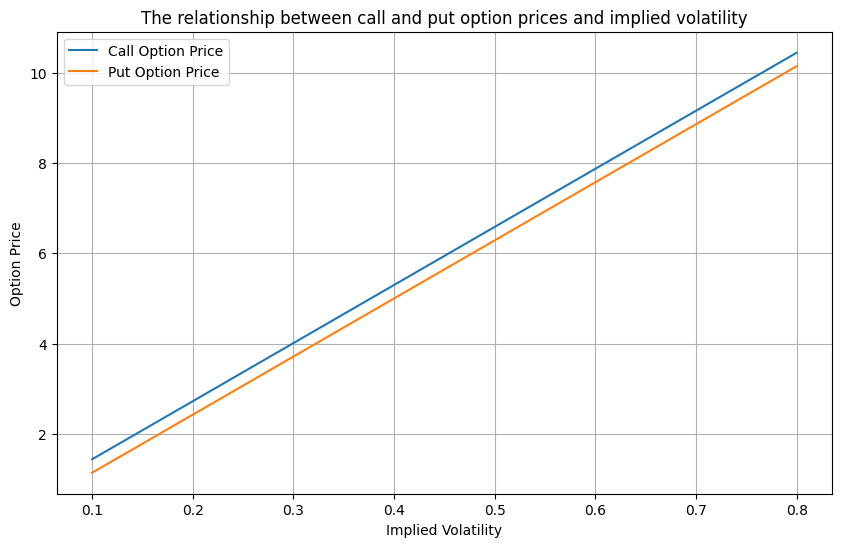

In [34]:
# price随隐含波动率变化的图表
plt.figure(figsize=(10, 6))
plt.plot(volatilities, call_prices, label='Call Option Price')
plt.plot(volatilities, put_prices, label='Put Option Price')
plt.xlabel("Implied Volatility")
plt.ylabel("Option Price")
plt.title("The relationship between call and put option prices and implied volatility")
plt.legend()
plt.grid(True)
plt.show()

隐含波动率对期权价格的影响
   - 图中显示，随着隐含波动率的增加，看涨期权和看跌期权的价格均呈现出线性上升的趋势。这是因为较高的隐含波动率意味着市场预期标的资产的未来价格波动性更大，因此期权的价值也随之增加。
   - 从图中可以看出，期权价格（纵轴）对隐含波动率（横轴）非常敏感，这说明隐含波动率是影响期权价格的重要因素。

供需如何影响隐含波动率
   - 当市场对期权的需求增加（例如，投资者预期未来市场波动性增加时，会大量买入期权），这种需求的上升会推高期权价格。为了反映更高的期权价格，隐含波动率也会上升。
   - 反之，如果市场上期权的供给较大且需求不足，期权价格会下降，从而导致隐含波动率下降。
   
综上，图表展示了隐含波动率对期权价格的直接影响，而隐含波动率本身也会受到市场供需关系的驱动。当期权需求增加时，隐含波动率上升，从而导致期权价格上升；当期权供给充足但需求较低时，隐含波动率下降，期权价格也随之下降。

The impact of implied volatility on option prices  
   - The chart shows that as implied volatility increases, both call and put option prices exhibit a linear upward trend. This is because higher implied volatility indicates that the market expects greater future price fluctuations in the underlying asset, thereby increasing the value of the options.
   - From the chart, it is clear that option prices (on the y-axis) are very sensitive to implied volatility (on the x-axis), which highlights that implied volatility is a significant factor affecting option prices.

How supply and demand affect implied volatility  
   - When demand for options increases (for example, if investors expect future market volatility to rise and thus buy a large volume of options), this increase in demand will drive up option prices. To reflect these higher option prices, implied volatility also rises.
   - Conversely, if there is a surplus of options in the market and insufficient demand, option prices will fall, leading to a decrease in implied volatility.

In summary, the chart demonstrates the direct impact of implied volatility on option prices, while implied volatility itself is influenced by market supply and demand dynamics. When option demand increases, implied volatility rises, resulting in higher option prices. Conversely, when there is ample supply but low demand, implied volatility decreases, and option prices also fall.

# Problem 2  
Use the options found in AAPL_Options.csv  
● Current AAPL price is 170.15  
● Current Date: 10/30/2023  
● Risk Free Rate: 5.25%  
● Dividend Rate: 0.57%.  
Calculate the implied volatility for each option.  
Plot the implied volatility vs the strike price for Puts and Calls. Discuss the shape of these graphs. What market dynamics could make these graphs?

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

data = pd.read_csv("/Users/apple/Desktop/FT545 - Week6/AAPL_Options.csv")

# 已知参数
S = 170.15  # 当前苹果公司股价
r = 0.0525  # 无风险利率（5.25%）
q = 0.0057  # 股息收益率（0.57%）
current_date = pd.to_datetime("2023-10-30")  # 当前日期

In [36]:
# 处理日期并计算年化到期时间

# 转换到期日并计算年化到期时间
data['Expiration'] = pd.to_datetime(data['Expiration'])
data['TimeToMaturity'] = (data['Expiration'] - current_date).dt.days / 365


In [37]:
# 定义Black-Scholes期权定价公式

# 定义Black-Scholes公式来计算期权价格
def black_scholes_price(S, K, T, r, q, sigma, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # 根据期权类型返回相应价格
    if option_type == "Call":  # 看涨期权
        price = np.exp(-q * T) * S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    elif option_type == "Put":  # 看跌期权
        price = np.exp(-r * T) * K * norm.cdf(-d2) - np.exp(-q * T) * S * norm.cdf(-d1)
    else:
        raise ValueError("期权类型应为 'Call' 或 'Put'")
    
    return price

In [38]:
# 定义隐含波动率计算函数

# 定义隐含波动率的计算函数
def implied_volatility(S, K, T, r, q, market_price, option_type):
    # 目标函数，用于计算理论价格与市场价格的差异
    def objective_function(sigma):
        return (black_scholes_price(S, K, T, r, q, sigma, option_type) - market_price) ** 2
    
    # 使用数值优化来最小化目标函数
    result = minimize(objective_function, x0=0.2, bounds=[(0.01, 3.0)])
    return result.x[0] if result.success else np.nan


In [39]:
# 计算每个期权的隐含波动率

# 使用apply方法对每一行数据计算隐含波动率
data['ImpliedVolatility'] = data.apply(
    lambda row: implied_volatility(S, row['Strike'], row['TimeToMaturity'], r, q, row['Last Price'], row['Type']),
    axis=1
)


In [40]:
# 分别获取看涨期权和看跌期权数据

# 按照期权类型分割数据集
calls = data[data['Type'] == 'Call']
puts = data[data['Type'] == 'Put']

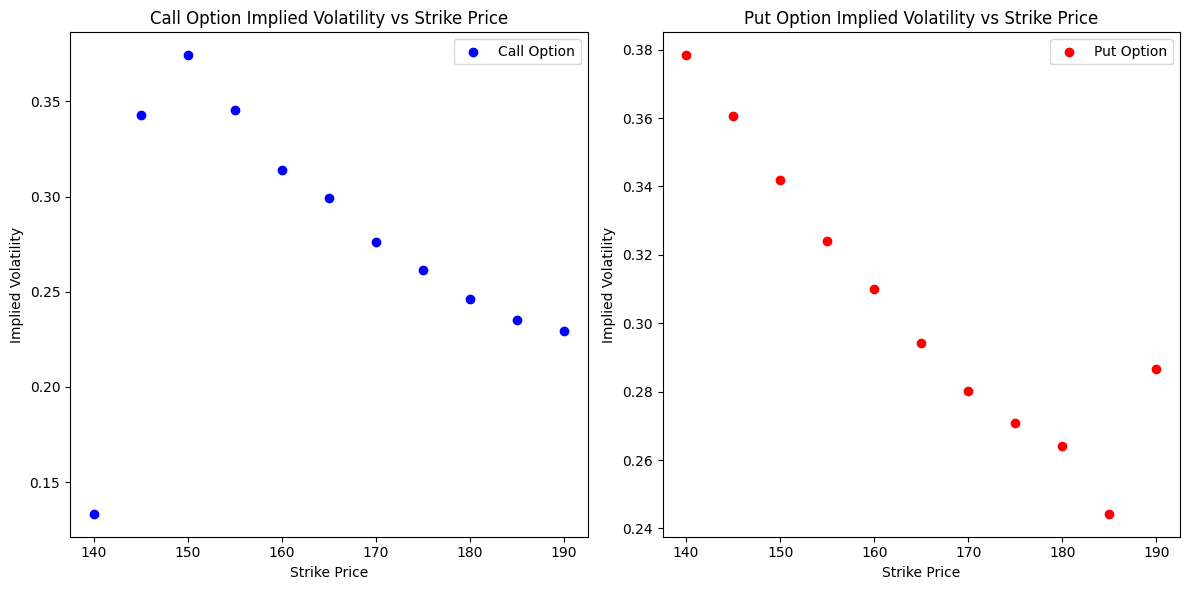

In [41]:
# 绘制Implied Volatility与Strike Price的关系图

plt.figure(figsize=(12, 6))

# 看涨期权Implied Volatility图
plt.subplot(1, 2, 1)
plt.scatter(calls['Strike'], calls['ImpliedVolatility'], color='blue', label='Call Option')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Call Option Implied Volatility vs Strike Price')
plt.legend()

# 看跌期权Implied Volatility图
plt.subplot(1, 2, 2)
plt.scatter(puts['Strike'], puts['ImpliedVolatility'], color='red', label='Put Option')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Put Option Implied Volatility vs Strike Price')
plt.legend()

plt.tight_layout()
plt.show()


隐含波动率随执行价格下降：
无论是看涨期权还是看跌期权，隐含波动率都随着执行价格的上升而下降。这种关系显示了隐含波动率和执行价格之间的负相关性。
“微笑”效应的缺乏：
通常情况下，隐含波动率曲线可能会呈现“微笑”形状（即执行价格越高或越低，隐含波动率越大），而在这里并没有出现明显的“微笑”或“倾斜”形状。这表明市场可能认为价格会保持在当前范围内波动，导致隐含波动率在执行价格较高时降低。

**Implied volatility decreases with strike price:**
For both call and put options, implied volatility decreases as the strike price increases. This relationship indicates a negative correlation between implied volatility and strike price.

**Lack of a “smile” effect:**
Typically, an implied volatility curve may show a “smile” shape, where implied volatility is higher for both lower and higher strike prices. However, in this case, there is no clear “smile” or “skew” shape. This suggests that the market expects prices to remain within the current range, leading to lower implied volatility at higher strike prices.

# Problem 3  
Use the portfolios found in problem3.csv  
● Current AAPL price is 170.15  
● Current Date: 10/30/2023  
● Risk Free Rate: 5.25%  
● Dividend Rate: 0.57%.  

For each of the portfolios, graph the portfolio value over a range of underlying values.  
Plot the portfolio values and discuss the shapes. Use put-call-parity to explain these graphs.    
Using DailyPrices.csv. Calculate the log returns of AAPL. Demean the series so there is 0 mean.  
Fit an AR(1) model to AAPL returns.  
Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above).  
Calculate Mean, VaR and ES. Discuss.  

Hints:  
● you will need to calculate the implied volatility - might not be the same as #2  
● you need to take into account the change in dates for option valuations. You are simulating forward in time and options valuations are a function of time  
● Calculate the PL from the current portfolio value using Current Date

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton

In [57]:
# Black-Scholes公式，用于计算欧式期权的理论价值
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """计算欧式期权的Black-Scholes价格"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

In [58]:
# 隐含波动率计算，使用Newton方法求解
def implied_volatility(S, K, T, r, market_price, option_type="call"):
    """通过市场价格计算隐含波动率，初始猜测值为1"""
    def bs_price_diff(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        # 使用Newton方法，初始猜测值为1，更贴近Julia的find_zero实现
        return newton(bs_price_diff, x0=1)
    except RuntimeError:
        return np.nan  # 如果无法求解，返回NaN

In [60]:
# 基本数据

# 设置初始条件和常量
current_price = 170.15  # 当前AAPL股票价格
risk_free_rate = 0.0525  # 无风险利率
dividend_rate = 0.0057  # 股息率

problem3_data = pd.read_csv('/Users/apple/Desktop/FT545 - Week6/problem3.csv')
problem3_data['OptionType'] = problem3_data['OptionType'].astype(str)
problem3_data['OptionType'] = problem3_data['OptionType'].replace('nan', np.nan)
problem3_data = problem3_data.dropna(subset=['OptionType'])


In [61]:
# 计算期权的到期时间并求解隐含波动率

# 计算每个期权的到期时间（以年为单位）
problem3_data['TimeToMaturity'] = (pd.to_datetime(problem3_data['ExpirationDate']) - pd.to_datetime("2023-10-30")).dt.days / 365

# 计算每个期权的隐含波动率
problem3_data['ImpliedVolatility'] = problem3_data.apply(
    lambda row: implied_volatility(
        S=current_price,
        K=row['Strike'],
        T=row['TimeToMaturity'],
        r=risk_free_rate,
        market_price=row['CurrentPrice'],
        option_type=row['OptionType'].lower()
    ),
    axis=1
)


In [62]:
# 定义函数来计算组合价值并绘图

# 定义函数计算组合价值
def calculate_portfolio_value_with_iv(data, prices, r):
    """使用隐含波动率计算组合价值"""
    portfolio_values = []
    for price in prices:
        total_value = 0
        for _, row in data.iterrows():
            T = row['TimeToMaturity']
            K = row['Strike']
            holding = row['Holding']
            option_type = row['OptionType'].lower()
            sigma = row['ImpliedVolatility']  # 使用隐含波动率
            option_value = black_scholes(price, K, T, r, sigma, option_type=option_type)
            total_value += holding * option_value
        portfolio_values.append(total_value)
    return portfolio_values

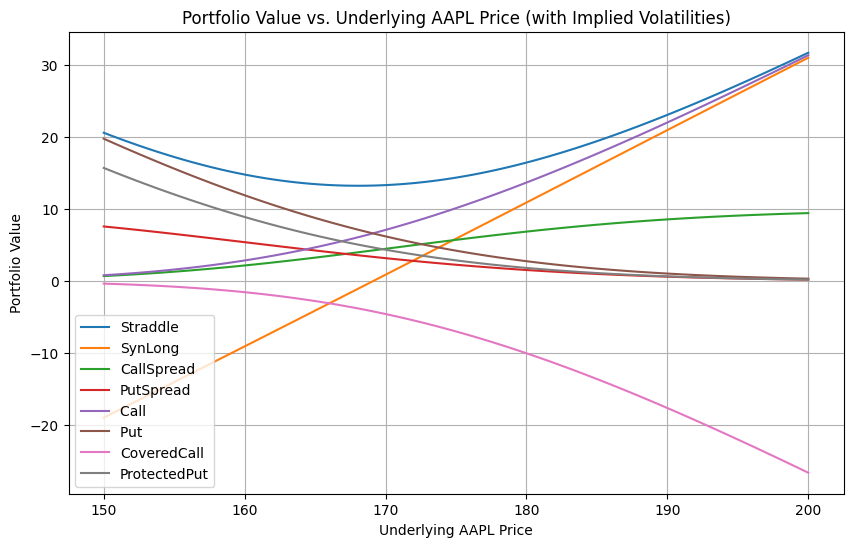

In [ ]:
# 生成价格范围并绘制组合价值曲线
 
# 生成AAPL基础价格范围
underlying_prices = np.linspace(150, 200, 100)

# 对每个组合类型计算组合价值并绘制图形
portfolios = problem3_data['Portfolio'].unique()
plt.figure(figsize=(10, 6))
for portfolio in portfolios:
    portfolio_data = problem3_data[problem3_data['Portfolio'] == portfolio]
    values = calculate_portfolio_value_with_iv(portfolio_data, underlying_prices, risk_free_rate)
    plt.plot(underlying_prices, values, label=portfolio)

plt.xlabel("Underlying AAPL Price")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value vs. Underlying AAPL Price (with Implied Volatilities)")
plt.legend()
plt.grid(True)
plt.show()

Put-Call Parity:  
Call Price - Put Price = Stock Price - Present Value of Strike Price

Straddle（跨式）
在图中，我们看到 Straddle 的组合价值随着 AAPL 价格的上升和下降而呈现对称的趋势，这符合预期。由于买卖权平价的关系，Straddle 组合在执行价附近的收益较低，而在价格远高于或低于执行价时收益较高。

*SynLong（合成多头）*
由于买卖权平价的关系，SynLong 组合的表现类似于直接持有股票的线性表现。图中 SynLong 组合的曲线随着 AAPL 价格的上涨呈线性上升，符合预期。

*CallSpread 和 PutSpread（价差组合）*
在图中，CallSpread 和 PutSpread 在价格变化时表现相对平稳，因为其上下限限制了风险，这种平稳特性与买卖权平价关系间接相关。

*CoveredCall 和 ProtectedPut（保护性策略）*
由于买卖权平价的影响，CoveredCall 的收益在价格上涨时受到限制，而 ProtectedPut 在价格下跌时受到保护。图中 CoveredCall 在高价格下平稳，而 ProtectedPut 在低价格下趋于平稳，这些都是平价关系的表现。

In [88]:
daily_prices = pd.read_csv('/Users/apple/Desktop/FT545 - Week6/DailyPrices.csv')

# 提取 AAPL 的价格数据
aapl_prices = daily_prices['AAPL']

# 计算对数收益率
log_returns = np.log(aapl_prices / aapl_prices.shift(1)).dropna()

# 去均值处理，使对数收益率的均值为 0
demeaned_log_returns = log_returns - log_returns.mean()

# 显示去均值后的对数收益率
print(demeaned_log_returns.head())


1   -0.014109
2   -0.008653
3    0.008807
4   -0.010069
5    0.018260
Name: AAPL, dtype: float64


In [65]:
from statsmodels.tsa.ar_model import AutoReg

# 拟合 AR(1) 模型
ar_model = AutoReg(demeaned_log_returns, lags=1).fit()

# 使用 AR(1) 模型模拟 AAPL 未来 10 天的收益率
simulated_returns = ar_model.predict(start=len(demeaned_log_returns), end=len(demeaned_log_returns) + 9)

# 输出模拟的 10 天未来收益率
print(simulated_returns)

265    0.000019
266    0.000053
267    0.000053
268    0.000053
269    0.000053
270    0.000053
271    0.000053
272    0.000053
273    0.000053
274    0.000053
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [97]:
# 当前 AAPL 价格
current_price = 170.15

# 拟合 AR(1) 模型，生成未来 10 天的收益率
ar_model = AutoReg(demeaned_log_returns, lags=1).fit()
simulated_returns = ar_model.predict(start=len(demeaned_log_returns), end=len(demeaned_log_returns) + 9)

# 计算未来价格路径
simulated_prices = [current_price * np.exp(r) for r in simulated_returns]

# 计算损失分布（基于当前价格与未来价格）
losses = [current_price - price for price in simulated_prices if current_price > price]  # 仅保留亏损

# 计算均值、VaR 和 ES
mean_price = np.mean(simulated_prices)  # 计算均值
var_99 = np.percentile(losses, 99) if losses else 0  # 99% VaR
es_99 = np.mean([loss for loss in losses if loss >= var_99]) if losses else 0  # 99% ES

# 输出结果
print("Average of AAPL price forecasts for the next 10 days： ${:.2f}".format(mean_price))
print("99% VaR: {:.2f}".format(var_99))
print("99% ES: {:.2f}".format(es_99))

Average of AAPL price forecasts for the next 10 days： $170.16
99% VaR: 0.00
99% ES: 0.00


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


在2023年10月30日至11月10日期间，AR(1)模型对AAPL价格的预测显示未来10天几乎没有下跌风险（99% VaR和99% ES均为0）。这与苹果公司在此期间的一系列利好公告相吻合，进一步验证了模型的合理性：
1. 发布M3系列芯片：10月30日，苹果公司推出了全新的M3、M3 Pro和M3 Max芯片。这一进展极大提升了苹果硬件产品的性能，增强了市场对其技术前景的信心。
2. 新款MacBook Pro发布：同日，苹果还推出了搭载M3芯片的MacBook Pro新机型，吸引了市场关注，为苹果股票提供了上升动力。
3. 财报超出预期**：11月2日发布的2023财年第四季度财报结果超出市场预期，提振了投资者的信心。
这些重大利好事件解释了市场对苹果股票的乐观情绪，因此AR(1)模型预测出未来10天几乎没有下跌风险是合理的。这段时间内，苹果股价表现稳定，符合模型预测。